In [1]:
import pandas as pd
import yaml
import pickle
import os
import logging
from utilities.utilities import *
from utilities.plotting import plot_exposure_contour, plot_gdp_increase_scatter
from utilities.plotting import plot_variable_map, plot_cdd_scatter, plot_variable_histogram, plot_income_groups

In [2]:
# Load configuration from config.yaml
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)
logging.basicConfig(level=config['logging_level'])

# Read in often used values from config
with open('exposure_function_params_{0}.pkl'.format(config['availability_function']), 'rb') as f:
    params = pickle.load(f)

if config['availability_function'] == 'power_law':
    avail_func = power_avail
elif config['availability_function'] == 'exponential':
    avail_func = exp_avail
elif config['availability_function'] == 'combined_exponential':
    avail_func = None
else:
    raise ValueError('Availability function not recognized')

ref_year = config['analysis_years']['ref_year']
past_year = config['analysis_years']['past_year']
future_year = config['analysis_years']['future_year']

outfile_path = config['output_path']

# Read in income groups from World Bank data
income_groups = pd.read_excel(config['world_bank_income_groups_file'])
income_groups = income_groups[['Code', 'Income group']]

In [3]:
def exposure_new(cdd, gdp):
    if avail_func is not None:
        return exposure_function((cdd, gdp), avail_func, params['cdd_scale'], params['alpha'], params['k'])
    else:
        return exposure_combined_exponential((cdd, gdp), params['cdd_scale'], params['alpha'], params['k'])

In [4]:
# Collect country-level data, only recalculate if the file does not exist

if os.path.exists(outfile_path):
    logging.info('Reading in experienced temperature data from file {}'.format(outfile_path))
    # Read in the data
    ac_data = pd.read_csv(outfile_path)

else:
    logging.info('Cooling deficit Index analysis results not found, recalculating')

    # Read the historical cooling degree days data
    cdd_data = read_cdd_data(config['cdd_historical_file'])
    

    # Read the historical GDP data
    gdp_data = read_gdp_data(config['gdp_historical_file'])
    gdp_data_years = []
    for year in [past_year, ref_year]:
        gdp_data_year = gdp_data[gdp_data['Year'] == year]
        fill_missing_country_gdp_data(year, gdp_data_year, config)
        if year == past_year:
            gdp_data_year = gdp_data_year.rename(columns={'GDP': 'GDP_past'})
            gdp_data_year = gdp_data_year.rename(columns={'Year': 'Year_past'})
        gdp_data_years.append(gdp_data_year)
    gdp_data = pd.merge(gdp_data_years[0], gdp_data_years[1], on='ISO3')

    ac_data_historical = pd.merge(cdd_data, gdp_data, on=['ISO3', 'Year'], how='left')
    ac_data_historical = ac_data_historical.rename(columns={'Year': 'Year_ref'})
        
    # Add historical annual GDP growth
    ac_data_historical['gdp_historical_growth'] = calculate_average_gdp_growth(ac_data_historical['GDP'], 
            ac_data_historical['GDP_past'], ac_data_historical['Year_ref'] - ac_data_historical['Year_past'])

    # Add predictions for CDD in 2100 in different scenarios
    cdd_projections = read_projections(config, 'cdd', ac_data_historical, year=config['analysis_years']['future_year'])
    
    # Combine historical and projections into one dataframe
    ac_data = pd.merge(ac_data_historical, cdd_projections, on='ISO3', how='outer')

    # Formatting
    # Drop rows where year past is NaN
    ac_data = ac_data.dropna(subset=['Year_past'])
    ac_data.reset_index(drop=True, inplace=True)
    ac_data['Year_past'] = ac_data['Year_past'].astype(int)
    # Replace infinities with empty values
    ac_data = ac_data.replace(np.inf, np.nan)

    # Add column for historical heat exposure
    ac_data['exposure_times_cdd'] = exposure_new(ac_data['CDD'], ac_data['GDP'])*ac_data['CDD']
    ac_data['ac_adoption'] = 1. - exposure_new(ac_data['CDD'], ac_data['GDP'])

    # Sort by income quantile and label each country with income group
    # ac_data['income_group'] = pd.qcut(ac_data['GDP'], 3, labels=config['income_groups'])
    ac_data = pd.merge(ac_data, income_groups, left_on='ISO3', right_on='Code', how='left').rename(columns={'Income group': 'income_group'})
    # Drop nans in income group
    ac_data = ac_data.dropna(subset=['income_group']).drop(columns=['Code'])
    # Income group names drop 'income' and make lower
    ac_data['income_group'] = ac_data['income_group'].str.replace(' income', '').str.lower()
    
    # Calculate GDP needed to keep heat exposure constant
    ac_data = calculate_gdp_const(ac_data, config, params)

    # Write full dataframe to csv
    if not os.path.exists(outfile_path):
        ac_data.to_csv(outfile_path)
    
    print(ac_data)



INFO:root:Reading in experienced temperature data from file data_experiencedT/cooling_deficit_index_calculations.csv


In [5]:
# Print ac adoption rates of high income countries
print('Adoption rates of high income countries')
print(ac_data[ac_data['income_group'] == 'high'][['Country', 'ac_adoption']])
print('mean')
print(ac_data[ac_data['income_group'] == 'high']['ac_adoption'].mean())

Adoption rates of high income countries
                          Country  ac_adoption
3                  American Samoa          NaN
5             Antigua and Barbuda     0.424895
8                           Aruba     0.694854
9                       Australia     0.634517
10                        Austria     0.567736
..                            ...          ...
194          United Arab Emirates     0.925769
195                United Kingdom     0.326297
197                 United States     0.764884
198  United States Virgin Islands          NaN
199                       Uruguay     0.302856

[73 rows x 2 columns]
mean
0.5270248474575554


In [6]:
# Get income group averages of CDD and GDP
ac_data_income_group = ac_data.drop(columns=['ISO3', 'Country'])
ac_data_income_group = ac_data_income_group.groupby('income_group').mean()
# Add row for global average
ac_data_income_group.loc['global average'] = ac_data_income_group.mean()

# Recalculate exposure times CDD for income groups
ac_data_income_group['exposure_times_cdd'] = exposure_new(ac_data_income_group['CDD'], ac_data_income_group['GDP'])*ac_data_income_group['CDD']

# Calculate GDP needed to keep exposure times CDD constant
for scenario in config['future_scenarios']:
    ac_data_income_group = calculate_gdp_const(ac_data_income_group, config, params)


# Add column to ac_data for GDP needed to get everyone to the exposure times cdd of the high income group
ac_data = calculate_gdp_const(ac_data, config, params, exp_cdd=ac_data_income_group.loc['high', 'exposure_times_cdd'])

INFO:root:Infinite GDP calculated for Index([], dtype='object', name='income_group'), possibly 0 CDD
INFO:root:Infinite GDP calculated for Index([], dtype='object', name='income_group'), possibly 0 CDD
INFO:root:Infinite GDP calculated for Index([], dtype='object', name='income_group'), possibly 0 CDD
INFO:root:Infinite GDP calculated for Index([], dtype='object', name='income_group'), possibly 0 CDD
INFO:root:Infinite GDP calculated for Index([], dtype='object', name='income_group'), possibly 0 CDD
INFO:root:Infinite GDP calculated for Index([], dtype='object', name='income_group'), possibly 0 CDD
INFO:root:Infinite GDP calculated for Index([], dtype='object', name='income_group'), possibly 0 CDD
INFO:root:Infinite GDP calculated for Index([], dtype='object', name='income_group'), possibly 0 CDD
INFO:root:Infinite GDP calculated for Index([], dtype='object', name='income_group'), possibly 0 CDD
INFO:root:Infinite GDP calculated for Index([70, 81], dtype='int64'), possibly 0 CDD
INFO:r

In [7]:
# Add CDD difference between 2100 and ref year
for scenario in config['future_scenarios']:
    ac_data['CDD_{0}_{1}_diff'.format(scenario, future_year)] = ac_data['CDD_{0}_{1}'.format(scenario, future_year)] - ac_data['CDD']
# Print gdp_const_ssp2_rcp45_custom_exp_cdd divided by gdp_const_ssp2_rcp45 for low income group and compute its mean
growth_ratio = ac_data[ac_data['income_group'] == 'low']['gdp_const_ssp2_rcp45_custom_exp_cdd']/ac_data[ac_data['income_group'] == 'low']['gdp_const_ssp2_rcp45']
print('GDP growth ratio for low income group: {}'.format(growth_ratio.mean()))

GDP growth ratio for low income group: 1.6871909210633063


In [8]:
# print(ac_data[ac_data['GDP_past'] > ac_data['GDP']])
# print when future CDD is less than past CDD
print(ac_data[ac_data['CDD_ssp1_rcp26_2100'] < ac_data['CDD']])
# print(ac_data[ac_data['gdp_const_ssp1_rcp26']<0])


     Unnamed: 0 ISO3           Country         CDD  Year_ref  Year_past  \
4             4  AGO            Angola  2169.94281      2019       1990   
9             9  AUS         Australia   790.79296      2019       1990   
36           37  CHL             Chile   175.72575      2019       1990   
38           39  COM           Comoros  2996.85716      2019       1990   
54           55  SLV       El Salvador  3111.70808      2019       1990   
60           61  FJI              Fiji  2627.50087      2019       1990   
63           64  PYF  French Polynesia  2827.62285      2019       1990   
70           71  GRL         Greenland     0.00023      2019       1990   
90           91  JAM           Jamaica  3097.91909      2019       1990   
94           95  KEN             Kenya  1471.73062      2019       1990   
99          100  KGZ        Kyrgyzstan   252.31133      2019       1990   
102         103  LBN           Lebanon  1056.62027      2019       1990   
108         109  MDG     

max kde 0.0003691134262754575


/carnegie/nobackup/scratch/awongel/clab_experiencedT/utilities/plotting_classes.py:80: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
/carnegie/nobackup/scratch/awongel/clab_experiencedT/utilities/plotting_classes.py:80: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
/carnegie/nobackup/scratch/awongel/clab_experiencedT/utilities/plotting_classes.py:80: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https:

max kde 0.0026352952741057105


/carnegie/nobackup/scratch/awongel/clab_experiencedT/utilities/plotting_classes.py:80: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
/carnegie/nobackup/scratch/awongel/clab_experiencedT/utilities/plotting_classes.py:112: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  empty_countries.plot(ax=plt.gca(), color='lightgrey')
/carnegie/nobackup/scratch/awongel/clab_experiencedT/utilities/plotting_classes.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


max kde 0.0016584608824091137


/carnegie/nobackup/scratch/awongel/clab_experiencedT/utilities/plotting_classes.py:80: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


max kde 0.0014274816096954215


/carnegie/nobackup/scratch/awongel/clab_experiencedT/utilities/plotting_classes.py:80: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
/carnegie/nobackup/scratch/awongel/clab_experiencedT/utilities/plotting_classes.py:112: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  empty_countries.plot(ax=plt.gca(), color='lightgrey')


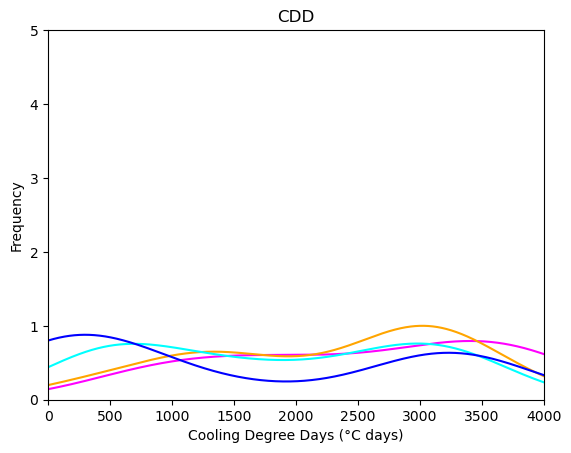

<Figure size 640x480 with 0 Axes>

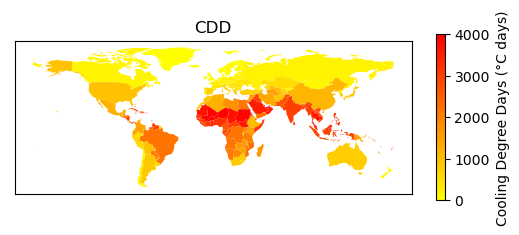

<Figure size 640x480 with 0 Axes>

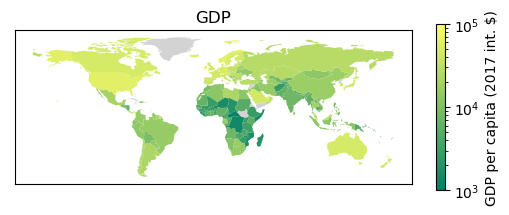

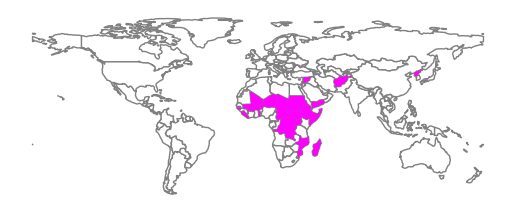

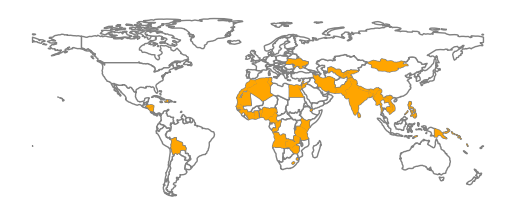

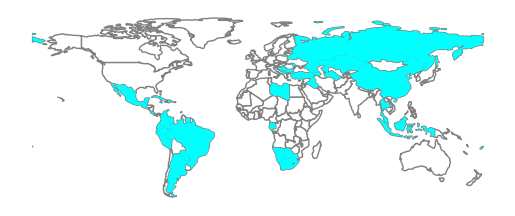

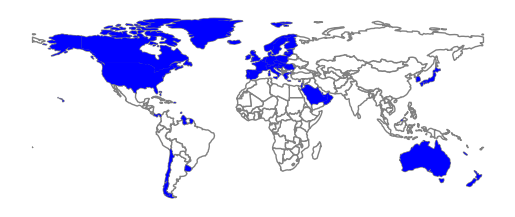

/home/awongel/miniconda3/envs/experiencedT_env/lib/python3.10/site-packages/matplotlib/text.py:1419: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(x))
/home/awongel/miniconda3/envs/experiencedT_env/lib/python3.10/site-packages/matplotlib/text.py:1421: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(y))
/home/awongel/miniconda3/envs/experiencedT_env/lib/python3.10/site-packages/matplotlib/text.py:830: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(self._x))
/home/awongel/miniconda3/envs/experiencedT_env/lib/python3.10/site-packages/matplotlib/text.py:831: FutureWarning: Calling float on a single element Series

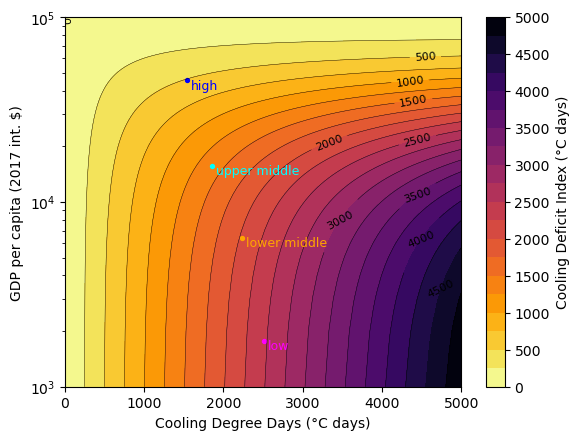

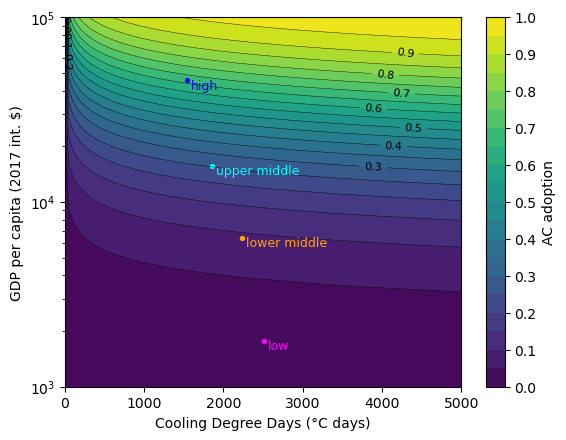

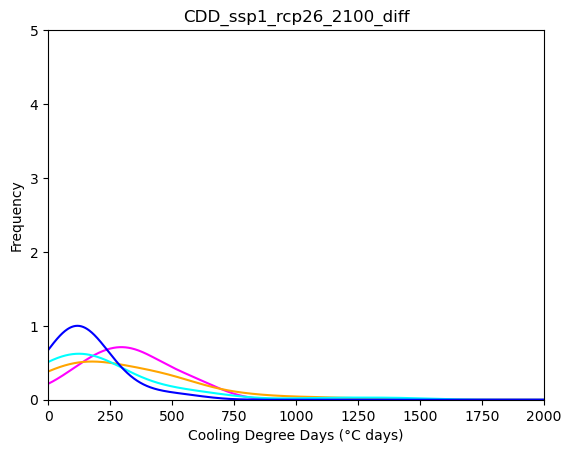

<Figure size 640x480 with 0 Axes>

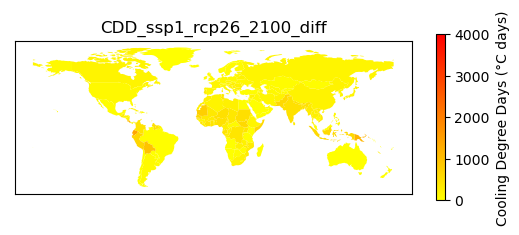

<Figure size 640x480 with 0 Axes>

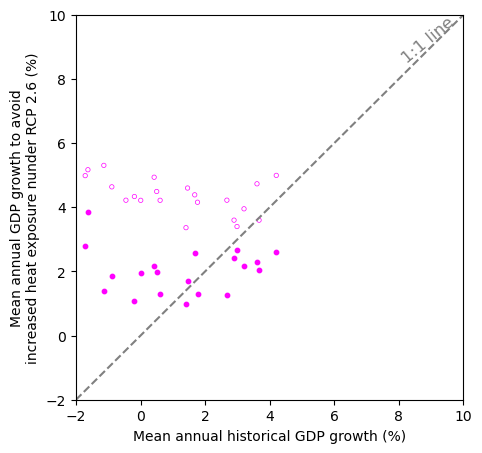

<Figure size 640x480 with 0 Axes>

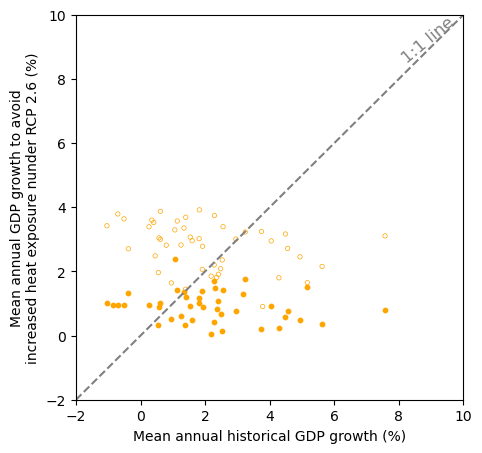

<Figure size 640x480 with 0 Axes>

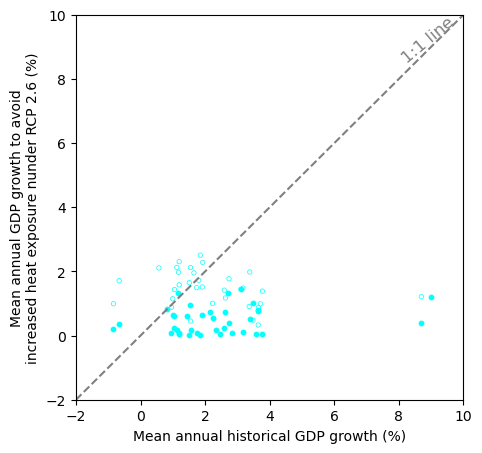

<Figure size 640x480 with 0 Axes>

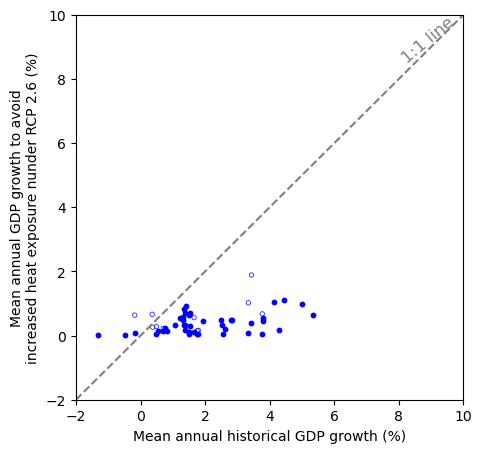

<Figure size 640x480 with 0 Axes>

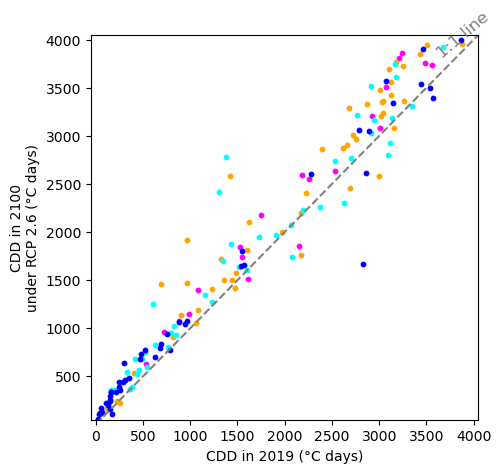

<Figure size 640x480 with 0 Axes>

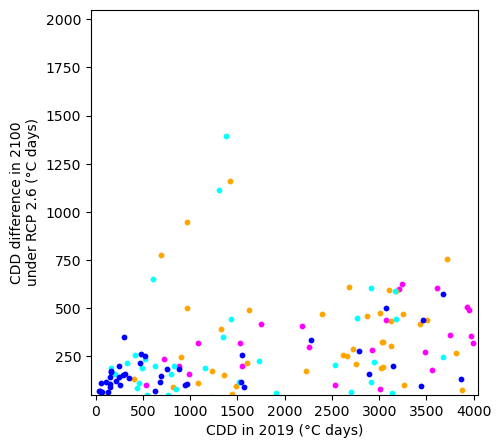

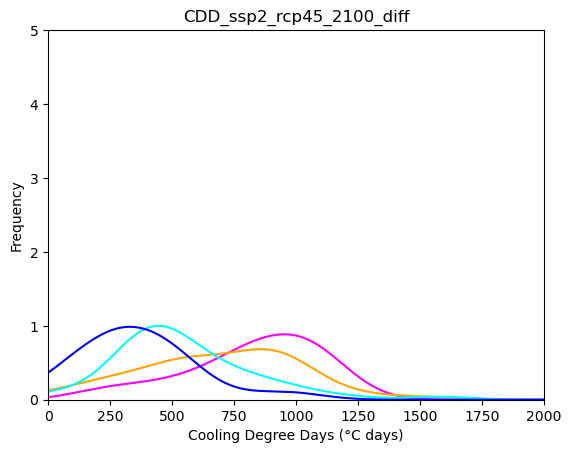

<Figure size 640x480 with 0 Axes>

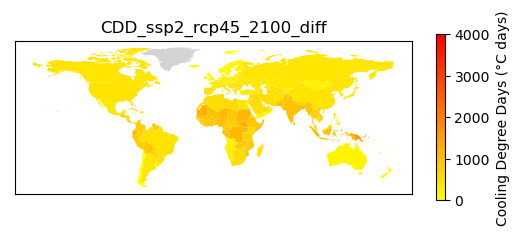

<Figure size 640x480 with 0 Axes>

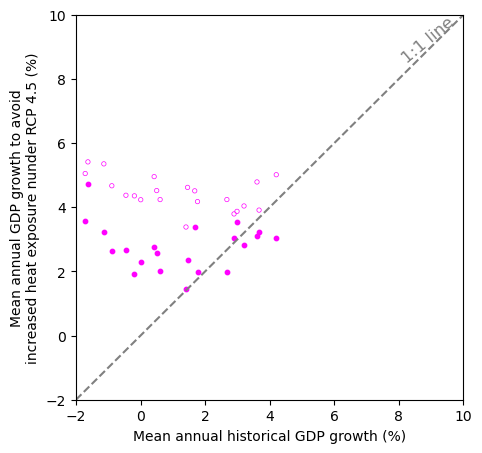

<Figure size 640x480 with 0 Axes>

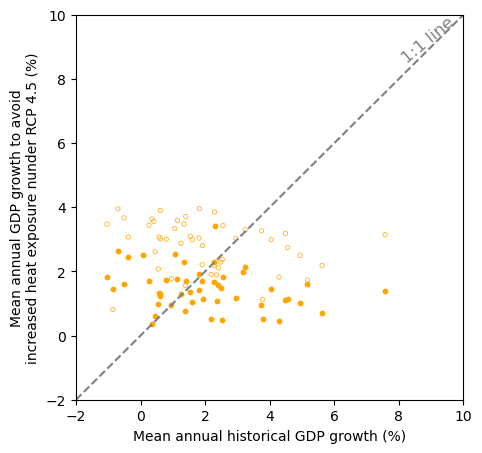

<Figure size 640x480 with 0 Axes>

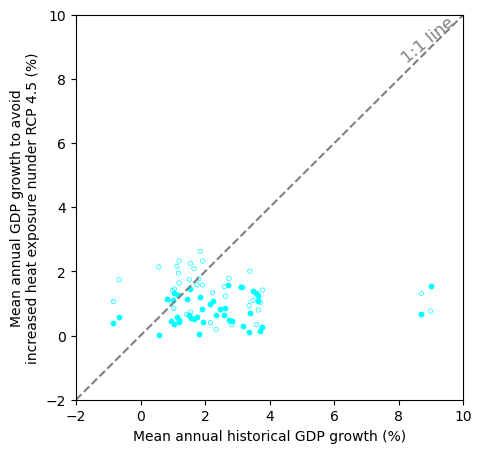

<Figure size 640x480 with 0 Axes>

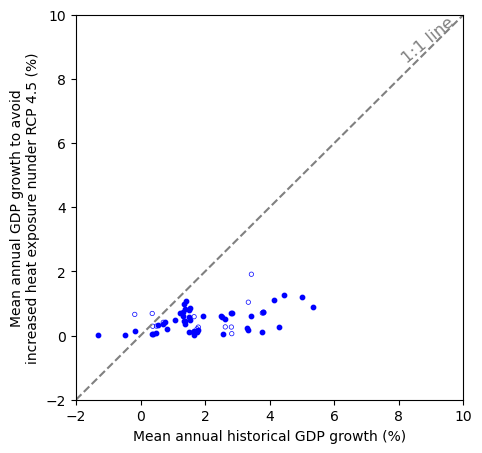

<Figure size 640x480 with 0 Axes>

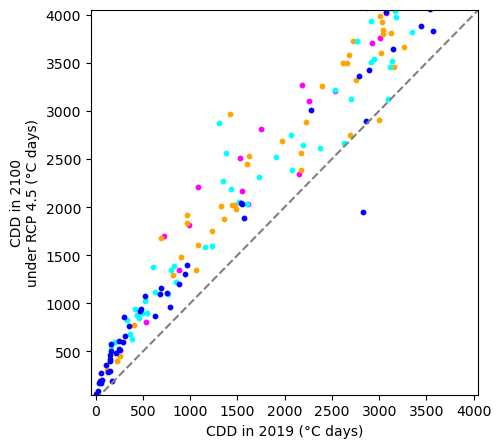

<Figure size 640x480 with 0 Axes>

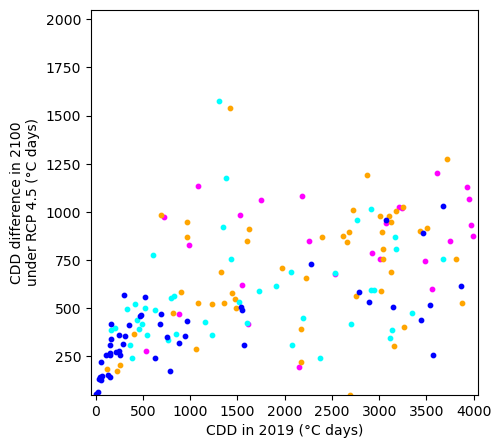

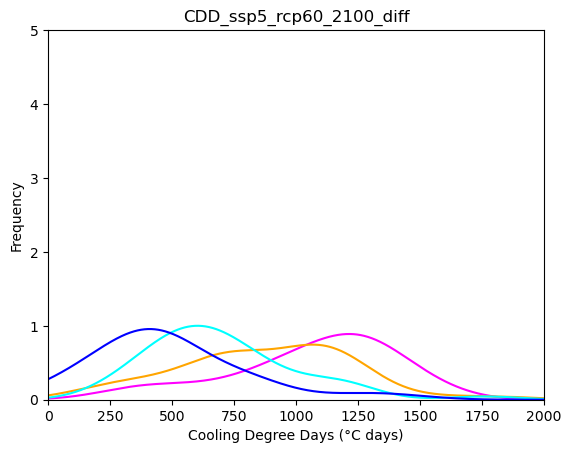

<Figure size 640x480 with 0 Axes>

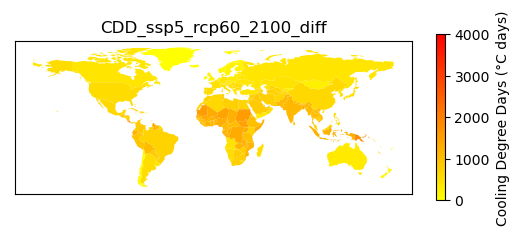

<Figure size 640x480 with 0 Axes>

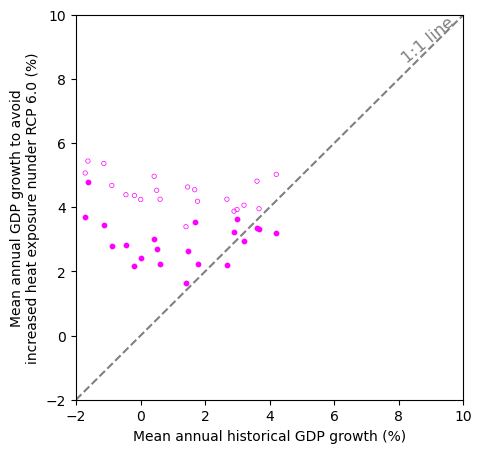

<Figure size 640x480 with 0 Axes>

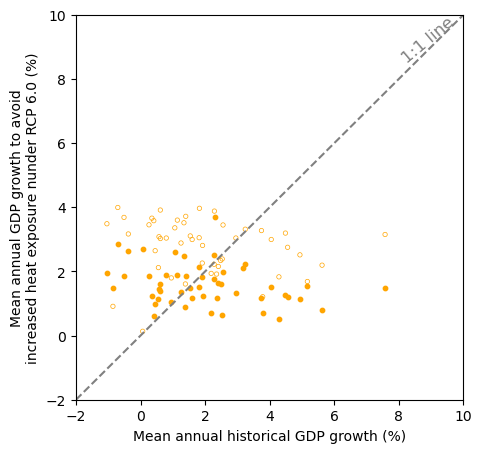

<Figure size 640x480 with 0 Axes>

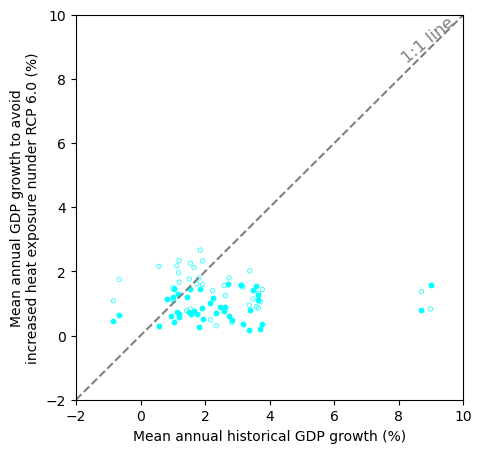

<Figure size 640x480 with 0 Axes>

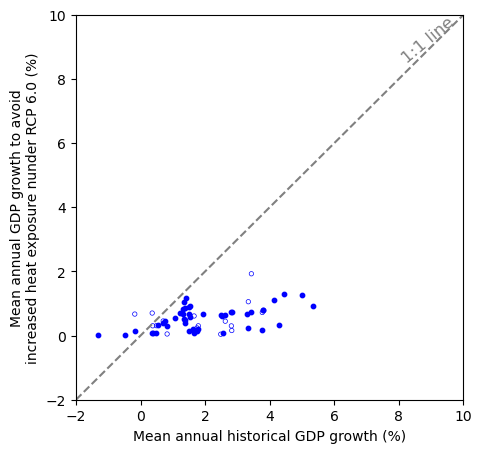

<Figure size 640x480 with 0 Axes>

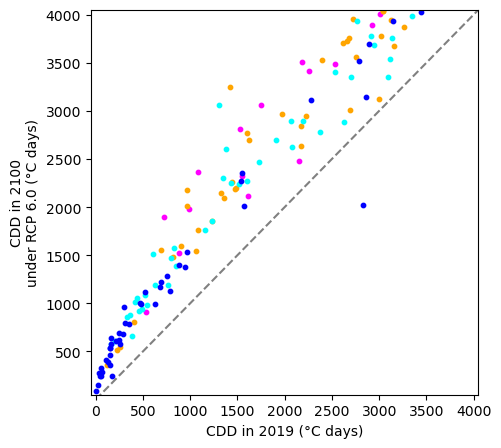

<Figure size 640x480 with 0 Axes>

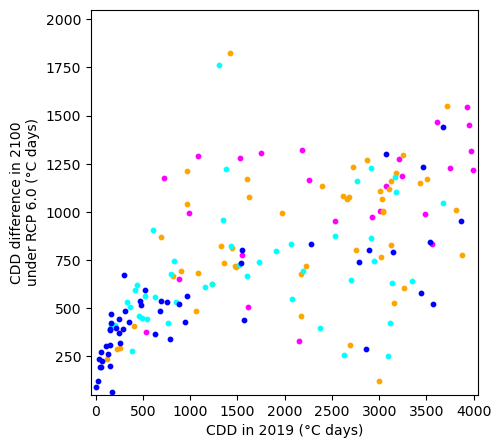

In [9]:
# Make all plots

for scenario in ['historical'] + config['future_scenarios']:

    # Parts of Figure CDD change (Fig.3)
    if scenario == 'historical':
        scen = ''
        vars = ['CDD', 'GDP']
    else:
        scen = '_'+scenario+'_2100_diff'
        vars = ['CDD_{}_2100_diff'.format(scenario)]
    plot_variable_histogram(config, ac_data, 'CDD'+scen)
    
    # Figure GDP and CDD maps (Fig.1)
    for var in vars:
        plot_variable_map(config, ac_data, var)
    
    if scenario == 'historical':
        # Plot maps highlighting income groups (Fig.4)
        plot_income_groups(config, ac_data)

        # Figure Contours (Fig.2)
        xrange = [config['plotting']['cdd_min'], config['plotting']['cooling_deficit_index_max'], 100]
        yrange = [config['plotting']['gdp_min'], config['plotting']['gdp_max'], 100]
        # Exposure times CDD
        plot_exposure_contour(config, exposure_new, ac_data_income_group, 
            x_y_ranges=[xrange, yrange], name_tag='exposure_contour')
        # AC adoption
        plot_exposure_contour(config, exposure_new, ac_data_income_group, 
            x_y_ranges=[xrange, yrange], name_tag='AC_adoption_contour', multiply_cdd=False)
        continue

    # Part of Figure GDP growth (Fig.4)
    plot_gdp_increase_scatter(config, ac_data, scenario)

    # Part of Figure CDD change (Fig.3)
    plot_cdd_scatter(config, ac_data, scenario)